# Import All the Libraries

In [81]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


# Install Additional Packages for web scrapping 

In [2]:
pip install BeautifulSoup4 requests

     |████████████████████████████████| 102kB 17.9MB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lxml

     |████████████████████████████████| 5.8MB 1.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Import additional libraries

In [4]:
import requests
from bs4 import BeautifulSoup
import lxml
import re

# Read the webpage and extract the RAW table information

In [5]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
source = BeautifulSoup(url.text, 'html.parser')
table = source.find_all('table',class_="wikitable sortable")

Parse through the table content and extract table row i.e. tags with "td"

In [6]:
for row in table:
    row_td = row.find_all('td')
    str_cells = str(row_td)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean,'',str_cells))

Cleanse the Extract row information and prepare the list

In [7]:
clean2 = clean2.replace('[','')
clean2 = clean2.replace(']','')
clean2 = clean2.replace('\n, ','\n')
clean2 = clean2.replace('"',"'")
lines = clean2.split('\n')
lines = lines[:-1]

# Load the table information into DataFrame

Initialize the Dataframe

In [8]:
column_names = ['PostalCode','Borough','Neighborhood'] 
# instantiate the dataframe
df = pd.DataFrame(columns=column_names)

Load the row information into Data Frame

In [9]:
for data in lines:
    line = data.split(',')
    PostalCode = line[0] 
    Borough = line[1]
    Neighborhood = line[2]    
   
    df = df.append({'PostalCode': PostalCode,
                    'Borough': Borough,
                    'Neighborhood': Neighborhood}, ignore_index=True)

Discarding the rows where Borough doesn't have any value i.e. Not Assigned

In [10]:
df = df[df.Borough !=' Not assigned']

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. Combining these rows into one row with the neighborhoods separated with a comma

In [11]:
df1 = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda tags: ','.join(tags))
df1 = df1.to_frame()
df1 = df1.reset_index()

Selecting rows where Neighborhood is not assigned

In [12]:
df1[df1.Neighborhood == ' Not assigned']

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Not assigned


Replacing such Neighborhood value with correspodning Borough

In [13]:
df1['Neighborhood'][df1.Neighborhood == ' Not assigned']=df1['Borough'][df1.Neighborhood == ' Not assigned']

verifying the data

In [14]:
df1[df1.Neighborhood == ' Not assigned']

,PostalCode,Borough,Neighborhood


In [15]:
df1[df1.PostalCode == "M7A"]

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Queen's Park


The size of the final Data Frame

In [16]:
df1.shape

(103, 3)

# Appending Latitude,Longitude information for each postal code

Reading the csv file which contains postal code wise Latitude, Longitude information

In [17]:
df3=pd.read_csv('http://cocl.us/Geospatial_data')

Renaming the Postal code column name to match with our data frame

In [18]:
df3.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df3.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Concatenate 2 data frames to have consolidated data frame 

In [19]:
toronto_data = pd.concat([df1, df3], sort=True, ignore_index=True, axis=1)

Lets check the data

In [20]:
toronto_data.head()

,0,1,2,3,4,5
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


Dropping unwanted columns and renaming the existing one

In [21]:
toronto_data.drop(3, axis=1 , inplace=True)
toronto_data.rename(columns={0: 'PostalCode',1: 'Borough',2: 'Neighborhood',4: 'Latitude',5: 'Longitude'}, inplace=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Use geopy library to get the latitude and longitude values of Toronto.

In [22]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


# Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = 'LOZ5UGC4Q1ERRNBQXNWXGEFU3JXBZXSIFEDMNVUL1BQD32TQ' # your Foursquare ID
CLIENT_SECRET = 'UMLEYDFRMEMXOTHQTZDIMDRX5FTHHTKIMWGJI3C3QBPNNNJD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LOZ5UGC4Q1ERRNBQXNWXGEFU3JXBZXSIFEDMNVUL1BQD32TQ
CLIENT_SECRET:UMLEYDFRMEMXOTHQTZDIMDRX5FTHHTKIMWGJI3C3QBPNNNJD


# Explore Neighborhoods in Manhattan

# Create a function

In [24]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Create a new data frame using above function

In [116]:
# type your answer here

toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

 Rouge, Malvern
 Highland Creek, Rouge Hill, Port Union
 Guildwood, Morningside, West Hill
 Woburn
 Cedarbrae
 Scarborough Village
 East Birchmount Park, Ionview, Kennedy Park
 Clairlea, Golden Mile, Oakridge
 Cliffcrest, Cliffside, Scarborough Village West
 Birch Cliff, Cliffside West
 Dorset Park, Scarborough Town Centre, Wexford Heights
 Maryvale, Wexford
 Agincourt
 Clarks Corners, Sullivan, Tam O'Shanter
 Agincourt North, L'Amoreaux East, Milliken, Steeles East
 L'Amoreaux West
 Upper Rouge
 Hillcrest Village
 Fairview, Henry Farm, Oriole
 Bayview Village
 Silver Hills, York Mills
 Newtonbrook, Willowdale
 Willowdale South
 York Mills West
 Willowdale West
 Parkwoods
 Don Mills North
 Flemingdon Park, Don Mills South
 Bathurst Manor, Downsview North, Wilson Heights
 Northwood Park, York University
 CFB Toronto, Downsview East
 Downsview West
 Downsview Central
 Downsview Northwest
 Victoria Village
 Woodbine Gardens, Parkview Hill
 Woodbine Heights
 The Beaches
 Leaside
 Thornclif

In [117]:
print(toronto_venues.shape)
toronto_venues.head()
#toronto_venues['Venue Category'].unique()

(2262, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


# Analyzing the neighborhood having majority number of restaurants

In [115]:
toronto_res_venues=toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]
toronto_res_venue_cnt=toronto_res_venues.groupby('Neighborhood').count()[['Venue']]
toronto_res_venue_cnt=toronto_res_venue_cnt.sort_values(by='Venue', ascending=False)
toronto_res_venue_cnt=toronto_res_venue_cnt.rename(columns={"Venue" : "Restaurant Venue Count"})
toronto_res_venue_cnt.columns
toronto_res_top15=toronto_res_venue_cnt['Restaurant Venue Count'].head(15)
toronto_res_top15

Neighborhood
 Chinatown, Grange Park, Kensington Market            35
 Adelaide, King, Richmond                             30
 Church and Wellesley                                 28
 Commerce Court, Victoria Hotel                       27
 First Canadian Place, Underground city               26
 St. James Town                                       24
 Design Exchange, Toronto Dominion Centre             24
 Central Bay Street                                   23
 Ryerson, Garden District                             23
 Stn A PO Boxes 25 The Esplanade                      21
 Little Portugal, Trinity                             20
 The Danforth West, Riverdale                         15
 Harbourfront East, Toronto Islands, Union Station    13
 Bedford Park, Lawrence Manor East                    11
 Berczy Park                                          11
Name: Restaurant Venue Count, dtype: int64

# Plot the top15 neighborhood having maxinum number of restaurants

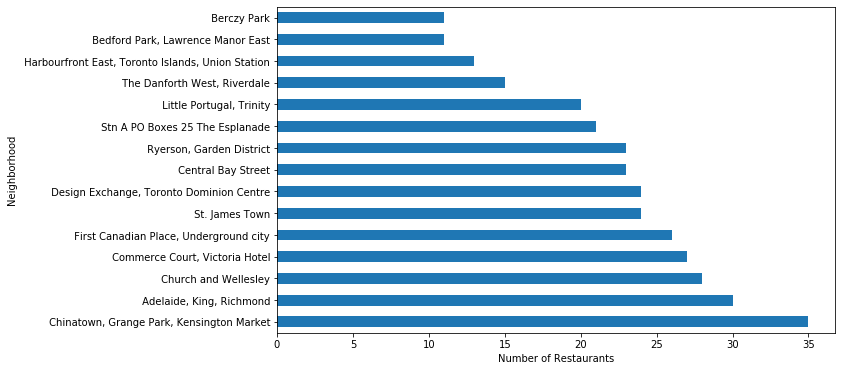

In [113]:
toronto_res_top15.plot(kind='barh',figsize=(10,6))
plt.xlabel('Number of Restaurants')
plt.show()

# Analyzing the neighborhood having other amenities like Tourist Site(Landmark/Historic/Monument, Airport, Bus, Hospital, Gym, School, Hotel/Motel, Shopping Mall, Theater, Metro, Bar/Pub

In [129]:
toronto_oth_venues=toronto_venues[toronto_venues['Venue Category'].str.contains("Landmark|Historic|Monument|Airport|Hospital|Bus |Gym|School|Hotel|Motel|Mall|Theater|Metro|Bar|Pub")]
toronto_oth_venue_cnt=toronto_oth_venues.groupby('Neighborhood').count()[['Venue']]
toronto_oth_venue_cnt=toronto_oth_venue_cnt.sort_values(by='Venue', ascending=False)
toronto_oth_venue_cnt=toronto_oth_venue_cnt.rename(columns={"Venue" : "Other Venue Count"})
toronto_oth_venue_cnt.head()

,Other Venue Count
Neighborhood,
"Commerce Court, Victoria Hotel",20
"Design Exchange, Toronto Dominion Centre",18
"Little Portugal, Trinity",17
"First Canadian Place, Underground city",17
Stn A PO Boxes 25 The Esplanade,16


# Concatenating the neighborhood details to have restaurant and other amenities count for each neighborhood

In [151]:
toronto_top_venue = pd.concat([toronto_res_venue_cnt, toronto_oth_venue_cnt], sort=True, ignore_index=True, axis=1)
toronto_top_venue = toronto_top_venue.fillna(0)
toronto_top_venue.rename(columns={0: 'Res Venue Count',1: 'Other Venue Count'}, inplace=True)
toronto_top_venue ['Avg Venue Count']=toronto_top_venue.mean(axis=1)
toronto_top_venue = toronto_top_venue.sort_values(['Avg Venue Count'], ascending=[False])

toronto_top_venue15=toronto_top_venue.head(15)

# Plot the neighborhood on basis of Average key venue count vs Total restaurant count vs Total other ameneties count

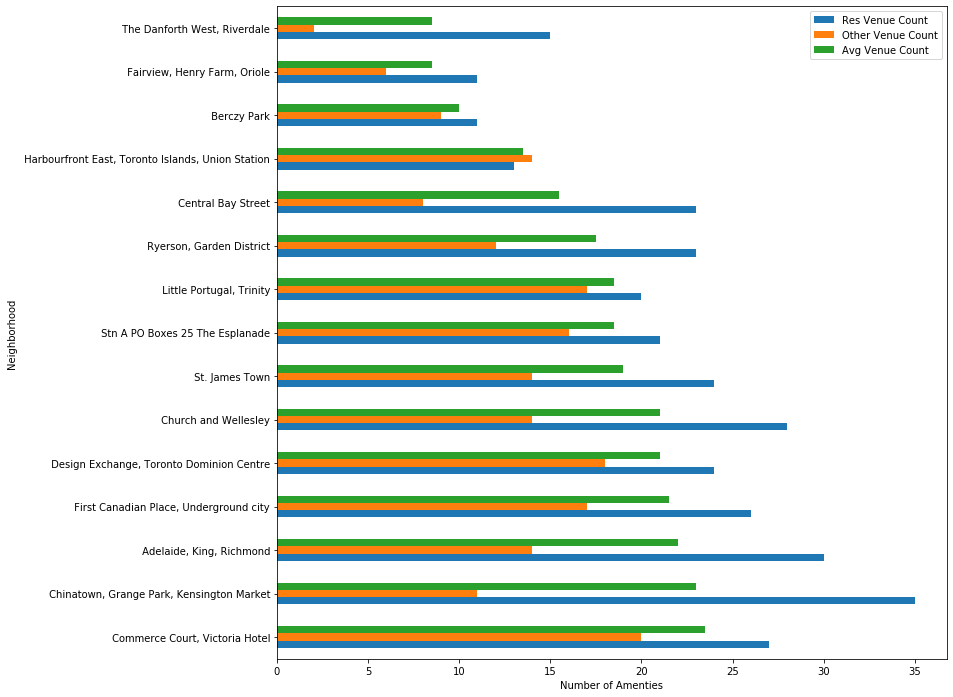

In [161]:
toronto_top_venue15.plot(kind='barh',figsize=(12,12))
plt.xlabel('Number of Amenties')
plt.ylabel('Neighborhood')
plt.show()

# The location can be decided on basis of Average Venue count which consider both restaurant and other amenities. Higher the average means the place is already proven to be good place to open up a restaurant and it has other amenities and facilities which will help in flourish a new restaurant 

Lets view the restaurant details of Commerce Court neighborhood which has scored the most in our Average Venue count analysis

In [158]:
toronto_venues[toronto_venues['Neighborhood'].str.contains("Commerce") & toronto_venues['Venue Category'].str.contains("Restaurant")]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1389,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Canoe,43.647452,-79.381320,Restaurant
1396,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
1406,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Ki Modern Japanese + Bar,43.647167,-79.379608,Japanese Restaurant
1409,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Bymark,43.647217,-79.381252,Restaurant
1410,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Kupfert & Kim (First Canadian Place),43.648547,-79.381624,Gluten-free Restaurant
1416,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Marché Mövenpick,43.647262,-79.378600,Restaurant
1417,"Commerce Court, Victoria Hotel",43.648198,-79.379817,John & Sons Oyster House,43.650656,-79.381613,Seafood Restaurant
1422,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Biff's Bistro,43.647085,-79.376342,French Restaurant
1423,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Richmond Station,43.651569,-79.379266,American Restaurant
1426,"Commerce Court, Victoria Hotel",43.648198,-79.379817,The Chase,43.650952,-79.379422,New American Restaurant


Let's check how many venues were returned for each neighborhood

In [ ]:
toronto_venues.groupby('Neighborhood').count()

# Analyze Each Neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [33]:
toronto_onehot.shape

(2262, 274)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [ ]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

lets confirm the new size

In [35]:
toronto_grouped.shape

(99, 274)

In [ ]:
toronto_grouped_transpose=toronto_grouped.T
toronto_grouped_transpose.head()

# Print each neighborhood along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

# Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Thai Restaurant,American Restaurant,Sushi Restaurant,Burger Joint,Asian Restaurant,Hotel,Steakhouse
1,Agincourt,Lounge,Sandwich Place,Skating Rink,Breakfast Spot,Drugstore,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, S...",Park,Playground,Coffee Shop,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate,...",Grocery Store,Pharmacy,Pizza Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Sandwich Place,Women's Store,Dog Run,Dessert Shop
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Pharmacy,Skating Rink,Sandwich Place,Pool,Pub,Women's Store,Diner


# Cluster Neighborhoods 

Run k-means to cluster the neighborhood into 5 clusters.

In [36]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Bar,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Department Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Medical Center,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Mexican Restaurant,Intersection,Women's Store,Dim Sum Restaurant,Diner
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Women's Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Fried Chicken Joint,Bakery,Hakka Restaurant,Athletics & Sports,Bank,Caribbean Restaurant,Thai Restaurant,Dog Run,Dim Sum Restaurant,Diner


Let's Change Cluster Labels into integer

In [38]:
toronto_merged['Cluster Labels'].unique()

array([ 0.,  1.,  4., nan,  2.,  3.])

In [39]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(0)

In [40]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged['Cluster Labels'].unique()

array([0, 1, 4, 2, 3])

In [41]:
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Bar,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Department Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Medical Center,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Mexican Restaurant,Intersection,Women's Store,Dim Sum Restaurant,Diner
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Women's Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Fried Chicken Joint,Bakery,Hakka Restaurant,Athletics & Sports,Bank,Caribbean Restaurant,Thai Restaurant,Dog Run,Dim Sum Restaurant,Diner


# Let's visualize resulting dataframe

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters